In [1]:
from sys import path
path.append('/home/rui/blacksid/mew-p')
DATA_PATH = '/home/rui/blacksid/data/dockfuture'
import numpy as np
import pytz
from datetime import datetime
import cProfile
import matplotlib.pyplot as plt
from mewp.simulate.report import Report

from mewp.simulate.wrapper import TrendAlgoWrapper
from mewp.simulate.runner import SingleRunner
import pandas
from mewp.util.clock import Clock
from mewp.util.candle import Candle
from mewp.util.candle import CandleCreator
from mewp.util.candle import CandleAnalysis

In [2]:
class ATR(object):
    ## Constructor
    # @param alpha for ema
    def __init__(self, alpha):
        self.alpha = alpha
        
        # computed
        self.mean = 0
        
    ## add a new observation, and refresh
    def add(self, observe):
        if (self.mean == 0):
            self.mean = observe
        else:
            self.mean = self.mean + self.alpha * (observe - self.mean)



## Algo

In [21]:
## 趋势突破
class TestAlgo(TrendAlgoWrapper):

    # called when algo param is set
    def param_updated(self):
        # make sure parent updates its param
        super(TestAlgo, self).param_updated()
        self.last_pnl = 0
        self.atr = ATR(0.1)
        self.pre_ma_pos = 0 # 1 represent ma1 > ma2, -1 represent ma1 < ma2
        self.pre_close = []
        self.history_high = None
        self.history_low = None
    # @param date Trading day
    # @param period Period of next tick
    # @param old_period The period that is ending
    def on_periodend(self, date, period, old_period):
        # example print info on period end
        timezone = pytz.timezone('Asia/Shanghai') 
        print 'Periodend {} period {:15s} -> {:15s}'.format(
                datetime.fromtimestamp(Clock.timestamp/1000, timezone),
                old_period, period)
        
    def on_daystart(self, date, info):
        print 'Daystart  {}'.format(date)
        self.start_time = Clock.timestamp
        # new candle for day, and new analyze
        if  hasattr(self, 'candle'):
            del self.candle
        self.candle = CandleCreator(self.param['min'], self.item.get_unit_perhand())
        
    def on_dayend(self, date, info): 
        # clear position if any
        #self.account.clear()
        # print pnl
        pnl = self.account.get_pnl()
        print 'Dayend    {} PNL {:10.1f} Day {:10.1f}'.format(date, pnl, pnl - self.last_pnl)
        self.param['daily_profit'].append(pnl - self.last_pnl)
        self.last_pnl = pnl
        # update candle, and day candle
        self.end_time = Clock.timestamp
    
    def update_lists(self, cur_candle):
        self.pre_close.append(cur_candle.close_price)
        if len(self.pre_close) > max(self.param['f2'], self.param['window2']):
            self.pre_close.pop(0)

    def buy_filter(self):
        if np.mean(self.pre_close[-self.param['f1']:]) > np.mean(self.pre_close[-self.param['f2']:]):
            return True
        else:
            return False
    
    def sell_filter(self):
        if np.mean(self.pre_close[-self.param['f1']:]) < np.mean(self.pre_close[-self.param['f2']:]):
            return True
        else:
            return False
    
    def buy_signal(self):
        new_ma_pos = np.mean(self.pre_close[-self.param['window1']:]) >\
                            np.mean(self.pre_close[-self.param['window2']:])
        if self.pre_ma_pos == False and new_ma_pos == True:
            return True
        return False
    
    def sell_signal(self):
        new_ma_pos = np.mean(self.pre_close[-self.param['window1']:]) >\
                            np.mean(self.pre_close[-self.param['window2']:])
        if self.pre_ma_pos == True and new_ma_pos == False:
            return True
        return False
    
    def on_tick(self, multiple, contract, info):
        new_candle = self.candle.on_tick(info, tickclass=True)
        if info.ask_1_price ==0 or info.bid_1_price == 0:
            return
        pos = self.position()
        if new_candle:
            cur_candle = self.candle.candles[-1]
            if len(self.pre_close) > 0:
                    TR = max(self.pre_close[-1], cur_candle.high) - min(self.pre_close[-1], cur_candle.low)
                    self.atr.add(TR)
            if len(self.pre_close) < max(self.param['f2'], self.param['window2']):
                self.update_lists(cur_candle)
                print len(self.pre_close)
                return
            if self.pre_ma_pos == 0:
                self.pre_ma_pos = np.mean(self.pre_close[-self.param['window1']:]) >\
                            np.mean(self.pre_close[-self.param['window2']:])

            self.update_lists(cur_candle)
            
            if self.buy_signal() and self.buy_filter():
                qty = np.min([self.param['cap']-pos,1]) if pos >= 0 else (-pos + 1)
                order = self.long(qty = qty)
                self.history_high = info.ask_1_price
                self.history_low = None
            elif self.sell_signal() and self.sell_filter():
                qty = np.min([self.param['cap']+pos,1]) if pos <= 0 else (pos + 1)
                order = self.short(qty=qty)
                self.history_high = None
                self.history_low = info.bid_1_price
        pos = self.position()
        #ATR stoploss
        if pos > 0:
            assert(self.history_high!=None)
            if info.bid_1_price > self.history_high:
                self.history_high = info.bid_1_price
            diff = self.history_high - info.bid_1_price
            assert(diff>=-1e-6)
            if diff > self.param['ATR_stoploss'] * self.atr.mean:
                print 'Clear'
                self.account.clear()
                self.history_high = None
            
        if pos < 0:
            assert(self.history_low!=None)
            if info.ask_1_price < self.history_low:
                self.history_low = info.ask_1_price
            diff = info.ask_1_price - self.history_low
            assert(diff>=-1e-6)
            if diff > self.param['ATR_stoploss'] * self.atr.mean:
                print 'Clear'
                self.account.clear()
                self.history_low = None

## Runner

In [23]:
dates = [str(x).split(' ')[0] for x in pandas.date_range('2015-01-01','2015-06-30').tolist()]
algo = { 'class': TestAlgo }
daily_profit = []
algo['param'] = {'item': 'cu', 'min': 5, 'window1': 10, 'window2':100,'cap': 1, 'f1': 50, 'f2': 100,
                 'ATR_stoploss': 12, 'daily_profit': daily_profit}
settings = { 'date': dates, 'algo': algo, 'tickset': 'top',
             'path': DATA_PATH }

In [24]:
runner = SingleRunner(settings)
runner.run()
#Profile.run('runner.run()', sort='cumtime')

Reading configs ...
Reading data ...
Skipping date 2015-01-01 ...
Skipping date 2015-01-02 ...
Skipping date 2015-01-03 ...
Skipping date 2015-01-04 ...
Reading item cu1503 starting 2015-01-05 ...
Skipping date 2015-01-10 ...
Skipping date 2015-01-11 ...
Skipping date 2015-01-17 ...
Skipping date 2015-01-18 ...
Reading item cu1504 starting 2015-01-22 ...
Skipping date 2015-01-24 ...
Skipping date 2015-01-25 ...
Skipping date 2015-01-31 ...
Skipping date 2015-02-01 ...
Skipping date 2015-02-07 ...
Skipping date 2015-02-08 ...
Skipping date 2015-02-14 ...
Skipping date 2015-02-15 ...
Reading item cu1505 starting 2015-02-17 ...
Skipping date 2015-02-18 ...
Skipping date 2015-02-19 ...
Skipping date 2015-02-20 ...
Skipping date 2015-02-21 ...
Skipping date 2015-02-22 ...
Skipping date 2015-02-23 ...
Skipping date 2015-02-24 ...
Skipping date 2015-02-28 ...
Skipping date 2015-03-01 ...
Skipping date 2015-03-07 ...
Skipping date 2015-03-08 ...
Skipping date 2015-03-14 ...
Skipping date 2015-

In [8]:
report = Report(runner)
dd = report.get_daily_pnl().daily_pnl
date_list = list(dd.index)
datetime_list = map(lambda x : datetime.strptime(x, '%Y-%m-%d'), date_list)

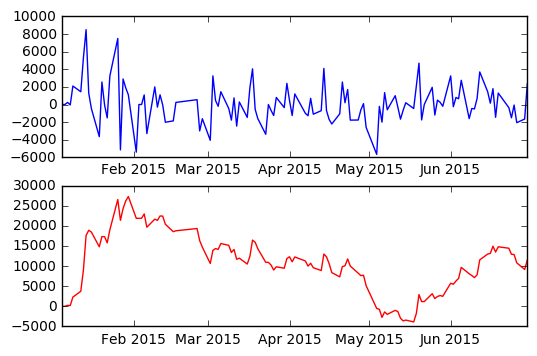

In [25]:
%matplotlib inline
fig, axes = plt.subplots(nrows = 2)
axes[0].plot(datetime_list,daily_profit)
axes[1].plot(datetime_list,np.cumsum(daily_profit),'r')

In [27]:
dates = [str(x).split(' ')[0] for x in pandas.date_range('2015-01-01','2015-06-30').tolist()]
algo = { 'class': TestAlgo }
daily_profit = []
algo['param'] = {'item': 'm', 'min': 5, 'window1': 10, 'window2':100,'cap': 1, 'f1': 50, 'f2': 100,
                 'ATR_stoploss': 10, 'daily_profit': daily_profit}
settings = { 'date': dates, 'algo': algo, 'tickset': 'top',
             'path': DATA_PATH }
runner = SingleRunner(settings)
runner.run()
#Profile.run('runner.run()', sort='cumtime')

Reading configs ...
Reading data ...
Skipping date 2015-01-01 ...
Skipping date 2015-01-02 ...
Skipping date 2015-01-03 ...
Skipping date 2015-01-04 ...
Reading item m1505 starting 2015-01-05 ...
Skipping date 2015-01-10 ...
Skipping date 2015-01-11 ...
Skipping date 2015-01-13 ...
Skipping date 2015-01-16 ...
Skipping date 2015-01-17 ...
Skipping date 2015-01-18 ...
Skipping date 2015-01-24 ...
Skipping date 2015-01-25 ...
Skipping date 2015-01-31 ...
Skipping date 2015-02-01 ...
Skipping date 2015-02-07 ...
Skipping date 2015-02-08 ...
Skipping date 2015-02-14 ...
Skipping date 2015-02-15 ...
Skipping date 2015-02-18 ...
Skipping date 2015-02-19 ...
Skipping date 2015-02-20 ...
Skipping date 2015-02-21 ...
Skipping date 2015-02-22 ...
Skipping date 2015-02-23 ...
Skipping date 2015-02-24 ...
Reading item m1509 starting 2015-02-26 ...
Skipping date 2015-02-28 ...
Skipping date 2015-03-01 ...
Skipping date 2015-03-02 ...
Skipping date 2015-03-07 ...
Skipping date 2015-03-08 ...
Skippin

In [28]:
report = Report(runner)
dd = report.get_daily_pnl().daily_pnl
date_list = list(dd.index)
datetime_list = map(lambda x : datetime.strptime(x, '%Y-%m-%d'), date_list)

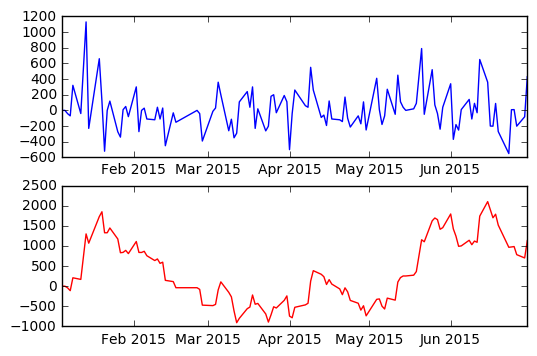

In [29]:
%matplotlib inline
fig, axes = plt.subplots(nrows = 2)
axes[0].plot(datetime_list,daily_profit)
axes[1].plot(datetime_list,np.cumsum(daily_profit),'r')
